In [1]:
import numpy.matlib as mat
import numpy.linalg as LA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cmath

#Constantes
c = 3e8
mu0 = 4*math.pi*1e-7
epsilon0 = 8.85e-12



Delta_aire = mat.zeros([4,4])
Delta_aire[0,1] = 1
Delta_aire[1,0] = 1
Delta_aire[2,3] = 1
Delta_aire[3,2] = 1

#Matriz de cambio de base i1,i2,r1,r2 a Ex,Hy,Ey,-Hx en el aire
T_aire = mat.zeros([4,4])
T_aire[0,0] = 1
T_aire[0,2] = 1
T_aire[1,0] = 1
T_aire[1,2] = -1
T_aire[2,1] = 1
T_aire[2,3] = 1
T_aire[3,1] = 1
T_aire[3,3] = -1


#Calculamos la matriz Delta a partir del tensor dielectrico

def getDelta(epsilon):
    delta = mat.zeros([4,4],dtype = np.complex128)
    delta[0,1] = 1
    delta[1,0] = epsilon[0,0]-epsilon[0,2]**2/epsilon[2,2]
    delta[1,2] = epsilon[0,1]-epsilon[0,2]*epsilon[1,2]/epsilon[2,2]
    delta[2,3] = 1
    delta[3,0] = delta[1,2]
    delta[3,2] = epsilon[1,1]-epsilon[1,2]**2/epsilon[2,2]
    return delta

#Calculamos la matriz de propagación para un z concreto

def getProp_i(medium,lamda):

    p = mat.eye(4,dtype = np.complex128)
    for i in range(medium.getNlayers()):
        h =  medium.getThicknes(i)
        epsilon = medium.getEpsilon(i)
        delta = getDelta(epsilon)
        [v,T] = LA.eig(delta)
        k = mat.zeros([4,4],dtype = np.complex128)
        for i in range(4):
            k[i,i] = cmath.exp(v[i]*2*math.pi*(h/lamda)*complex(0,1))
        
        p = p*T*k*LA.inv(T)

    return p

#Calculamos la matriz de propagación total

def getPropagation(medium,lamda, n_layers):
     #Propagación en el medio
    propagation = mat.eye(4,dtype = np.complex128)
    propagation_i = getProp_i(medium,lamda)
    for i in range(n_layers):
        propagation = propagation*propagation_i
        
    #Propagación medio-aire 
    propagation = propagation*T_aire
     #Propagación aire-medio 
    propagation = LA.inv(T_aire)*propagation
        
    return propagation
    

    
#Resolvemos el sistema para una cierta matriz de propagacion    
def calculateTransmision(i,medium,lamda,n_layers):
    
    propagation = getPropagation(medium,lamda,n_layers)
    t = LA.solve(propagation.copy()[[0,1],:][:,[0,1]],i)
    r = propagation.copy()[[2,3],:][:,[0,1]]*t
    return r,t
    
def calculateSpectrum(medium,incident,lamda_i,lamda_f,n_points,n_layers, print_progress = True):
    lamda = lamda_i
    r,t = calculateTransmision(incident,medium,lamda,n_layers)
    I = incident[0,0]*np.conj(incident[0,0])+ incident[1,0]*np.conj(incident[1,0])
    R = ((r[0,0]*np.conj(r[0,0])+r[1,0]*np.conj(r[1,0]))/I).real
    T = ((t[0,0]*np.conj(t[0,0])+t[1,0]*np.conj(t[1,0]))/I).real
    output = pd.DataFrame({"lamda":[lamda] , "R":[R] , "T":[T], "r_x":[r[0,0]],"r_y":[r[1,0]], "t_x":[t[0,0]],"t_y":[t[1,0]]})

    interval = (lamda_f-lamda_i)/n_points
    for i in range(n_points):
        if (i%(n_points/4) == 0 and print_progress):
            print("Iteración: ",i,", longitud de onda: ","{:.2E}".format(lamda))
            print("r: ",r,"\nt: ", t,"\n")
        lamda += interval
        r,t = calculateTransmision(incident,medium,lamda,n_layers)
        R = ((r[0,0]*np.conj(r[0,0])+r[1,0]*np.conj(r[1,0]))/I).real
        T = ((t[0,0]*np.conj(t[0,0])+t[1,0]*np.conj(t[1,0]))/I).real
        output = pd.concat([output,pd.DataFrame({"lamda":[lamda] , "R":[R] , "T":[T], "r_x":[r[0,0]],"r_y":[r[1,0]],"t_x":[t[0,0]],"t_y":[t[1,0]]})])
    if (print_progress):
        plt.figure();
        plt.plot(output["lamda"],output["T"], label ="T")
        plt.xlabel("wavelength(m)")
        plt.ylabel("Transmission")
    #plt.plot(output["lamda"],output["R"], label ="R")
    
    return output 
   
def calculateDOS(data,L,incident_x=1,incident_y=1):
    h = data.iloc[1]["lamda"]-data.iloc[0]["lamda"]
    XX = np.real(data["t_x"]/incident_x)
    XY = np.imag(data["t_x"]/incident_x)
    derXX = data["lamda"]**2*np.gradient(XX,h)/(2*math.pi)
    derXY = data["lamda"]**2*np.gradient(XY,h)/(2*math.pi)
    YX = np.real(data["t_y"]/incident_y)
    YY = np.imag(data["t_y"]/incident_y)
    derYX = data["lamda"]**2*np.gradient(YX,h)/(2*math.pi)
    derYY = data["lamda"]**2*np.gradient(YY,h)/(2*math.pi)
    data["DOS X"] = (1/L)*(derXY*XX-derXX*XY)/(XX*XX+XY*XY)
    data["DOS Y"] = (1/L)*(derYY*YX-derYX*YY)/(YX*YX+YY*YY)
    plt.figure();  
    plt.plot(output["lamda"],output["DOS X"], label ="DOS X")
    #plt.figure();  
    #plt.plot(output["lamda"],output["DOS Y"], label ="DOS Y")
    return data

def calculate_threshold(medium,incident,lamda_i,lamda_f,n_layers,precision,n_points=100):
    gamma = 0.1
    medium_exc = medium.getExcited(gamma)
    output = calculateSpectrum(medium_exc,incident,lamda_i,lamda_f,n_points,n_layers,False)
    t_max = output["T"].max()
    t_prov = t_max
    #Calculamos el orden de magnitud
    while t_prov >= t_max:
        t_max = t_prov
        gamma = gamma*0.1
        medium_exc = medium.getExcited(gamma)
        output = calculateSpectrum(medium_exc,incident,lamda_i,lamda_f,n_points,n_layers,False)
        t_prov = output["T"].max()
    p = gamma
    gamma = gamma*10
    t_prov = t_max
    medium_exc = medium.getExcited(gamma)
    output = calculateSpectrum(medium_exc,incident,lamda_i,lamda_f,n_points,n_layers,False)
    t_max = output["T"].max()
    while p>=precision:
        #Calculamos con precision p
        medium_exc = medium.getExcited(gamma)
        output = calculateSpectrum(medium_exc,incident,lamda_i,lamda_f,n_points,n_layers,False)
        t_max = output["T"].max()
        lamda_max = output.loc[output["T"] == t_max]["lamda"]
        delta_lamda = float(output.iloc[1]["lamda"]-output.iloc[0]["lamda"])
        lamda_i = float(lamda_max - delta_lamda*10)
        lamda_f = float(lamda_max + delta_lamda*10)
        gamma_prov = gamma + 10*p 
        print("Calculating with precision: ",p,",range: ",lamda_i,"-",lamda_f," current gamma: ",gamma, "current max transmission: ", t_max)
        for j in range(20):
            gamma_prov = gamma_prov - p
            medium_exc = medium.getExcited(gamma_prov)
            output = calculateSpectrum(medium_exc,incident,lamda_i,lamda_f,n_points,n_layers,False)
            t_prov = output["T"].max()
            if t_prov > t_max:
                t_max = t_prov
                gamma = gamma_prov
        p = p * 0.1
    
    return gamma


def saveImageTransmision(data,lamda1,lamda2,n1,n2,n_layers,gamma):
    plt.figure(figsize=(5,3.5));
    plt.plot(1e9*data["lamda"],data["T"],"red",linewidth = 1.5, label ="T")
    plt.xlabel("\u03BB(nm)", fontsize = 10)
    plt.ylabel("T", fontsize = 10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(color='grey', linestyle='-', linewidth=0.2)

    plt.savefig("T({:.2E},{:.2E})_n1_{:.2f}_n2_{:.2f}_nlay_{}_gamma_{:.2E}.pdf".format(lamda1,lamda2,n1,n2,n_layers,gamma))
    
def saveImageDOSX(data,lamda1,lamda2,n1,n2,n_layers,gamma):
    plt.figure(figsize=(5,3.5));
    plt.plot(1e9*data["lamda"],data["DOS X"],"red",linewidth = 1.5, label ="DOS X")
    plt.xlabel("\u03BB(nm)", fontsize = 10)
    plt.ylabel("DOS X", fontsize = 10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(color='grey', linestyle='-', linewidth=0.2)

    plt.savefig("DOSX({:.2E},{:.2E})_n1_{:.2f}_n2_{:.2f}_nlay_{}_gamma_{:.2E}.pdf".format(lamda1,lamda2,n1,n2,n_layers,gamma))
    

In [2]:
class PeriodicLayers:
    def __init__(self,n_list,thicknes):
        self.n_list = n_list
        self.thicknes = thicknes
        self.n_layers = len(n_list)
        
    
    def getEpsilon(self,i):
        return mat.eye(3)*(self.n_list[i]**2)
    
    def getThicknes(self,i):
        return self.thicknes[i]
    
    def getNlayers(self):
        return self.n_layers
    
    def getExcited(self,gamma):
        return PeriodicLayersExcited(self,self.n_layers*[gamma])
    
class PeriodicLayersExcited:
#    def __init__(self,n_list,thicknes,gamma_list):
 #       self.n_list = n_list
  #      self.gamma_list = gamma_list
   #     self.thicknes = thicknes
    #    self.n_layers = len(n_list)
    
    def __init__(self,medium,gamma_list):
        self.n_list = medium.n_list
        self.thicknes = medium.thicknes
        self.n_layers = medium.n_layers
        self.gamma_list = gamma_list
        
    
    def getEpsilon(self,i):
        epsilon = mat.eye(3,dtype = np.complex128)*(self.n_list[i]**2)*(1+self.gamma_list[i]*complex(0,1))
        return epsilon
    
    def getThicknes(self,i):
        return self.thicknes[i]
    
    def getNlayers(self):
        return self.n_layers


19.487478935121157


C:\Users\Jaime\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:1235: ComplexWarning: Casting complex values to real discards the imaginary part
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
C:\Users\Jaime\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:1256: ComplexWarning: Casting complex values to real discards the imaginary part
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
C:\Users\Jaime\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:1263: ComplexWarning: Casting complex values to real discards the imaginary part
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


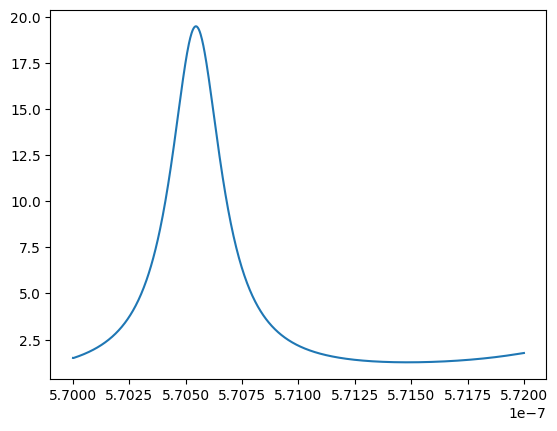

In [8]:


#Condiciones de discretización
lamda = 1e-7
n1 = 1.3
n2 = 1.45
gamma = 0
n_layers = 100
lamda1 = 5.7e-7
lamda2 = 5.72e-7
#Matriz dieléctrica
i = mat.array([[1],[1]])
medium = PeriodicLayers([n1,n2],[lamda,lamda])
#medium = PeriodicLayersExcited(medium,[gamma,gamma])
#getProp_i(medium,5.73e-7)
output = calculateSpectrum(medium,i, lamda1,lamda2,1000,n_layers,False)
#saveImageTransmision(output,lamda1,lamda2,n1,n2,n_layers,gamma)
#gamma = calculate_threshold(medium,i, 5.7e-7,5.9e-7,n_layers,1e-12)
L = sum(medium.thicknes)*n_layers
data = calculateDOS(output, L, i[0], i[1])
print(data["DOS X"].max())
#output.head()

#output.tail()





In [28]:
print(medium.getEpsilon(0))

[[1.69+0.00338j 0.  +0.j      0.  +0.j     ]
 [0.  +0.j      1.69+0.00338j 0.  +0.j     ]
 [0.  +0.j      0.  +0.j      1.69+0.00338j]]


In [53]:
gamma = 1.66e-3
lamda1 = 5.72440000000002e-07
lamda2 = 5.74e-07
medium_i = PeriodicLayersExcited(medium,[gamma,gamma])
output = calculateSpectrum(medium_i,i, lamda1,lamda2,1000,n_layers,False)
print(output["T"].max())

1970.2951917165228


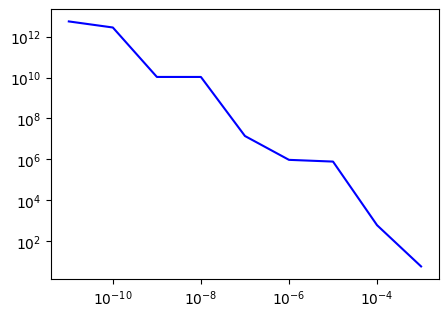

In [59]:
x = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11]
y = [6,619,788354,957139,13965868,10667007462,10680347545,2770232422880,5478308296309]
plt.figure(figsize=(5,3.5));
plt.plot(x,y,"blue",linewidth = 1.5, label ="R")
plt.yscale("log")
plt.xscale("log")

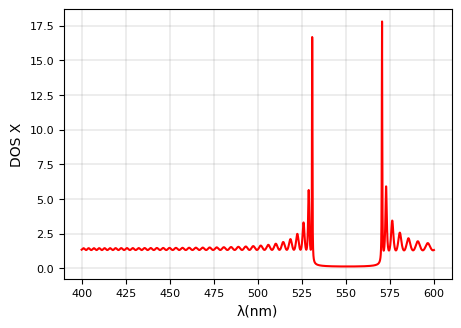

In [12]:
saveImageDOSX(data,lamda1,lamda2,n1,n2,n_layers,gamma)

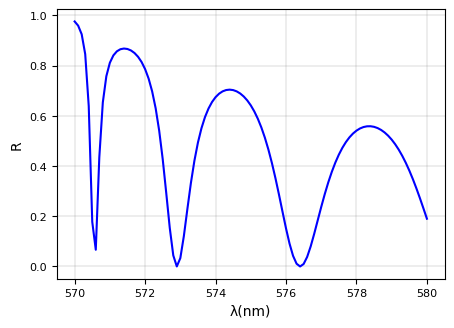

In [130]:
plt.figure(figsize=(5,3.5));
#plt.plot(1e7*output["lamda"],output["T"],"red",linewidth = 1.5, label ="T")
plt.plot(1e9*output["lamda"],output["R"],"blue",linewidth = 1.5, label ="R")
#plt.plot(1e9*output["lamda"],output["R"]+output["T"]-1,"black",linewidth = 1.5, label ="R")
plt.xlabel("\u03BB(nm)", fontsize = 10)
plt.ylabel("R", fontsize = 10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(color='grey', linestyle='-', linewidth=0.2)
#plt.savefig("4_1_2_R.pdf")

In [6]:
plt.savefig("4_1_2_3.pdf")

<Figure size 640x480 with 0 Axes>

In [5]:
lamda1 = 5.7275e-7
lamda2 = 5.73e-7

n1,n2 = 1.3,1.45
gamma = 2e-3
medium = PeriodicLayers([n1,n2],[lamda,lamda])
medium = PeriodicLayersExcited(medium,[gamma,gamma])
output1 = calculateSpectrum(medium,i, lamda1,lamda2,1000,n_layers,False)
gamma = 1.7e-3
medium = PeriodicLayers([n1,n2],[lamda,lamda])
medium = PeriodicLayersExcited(medium,[gamma,gamma])
output2 = calculateSpectrum(medium,i, lamda1,lamda2,1000,n_layers,False)
gamma = 1.66e-3
medium = PeriodicLayers([n1,n2],[lamda,lamda])
medium = PeriodicLayersExcited(medium,[gamma,gamma])
output3 = calculateSpectrum(medium,i, lamda1,lamda2,1000,n_layers,False)



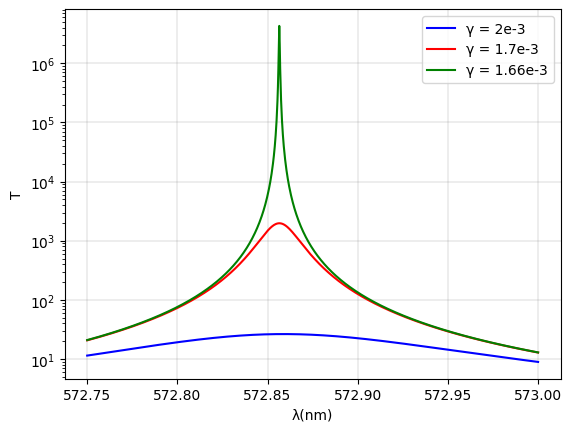

In [6]:
fig = plt.figure();



plt.plot(1e9*output1["lamda"],output1["T"],"blue", label ="\u03B3 = 2e-3")
plt.plot(1e9*output2["lamda"],output2["T"],"red", label ="\u03B3 = 1.7e-3")
plt.plot(1e9*output3["lamda"],output3["T"],"green", label ="\u03B3 = 1.66e-3")


plt.xlabel("\u03BB(nm)")
plt.ylabel("T")
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.legend()
plt.yscale("log")
plt.savefig("4_2_1_multi_2.pdf")

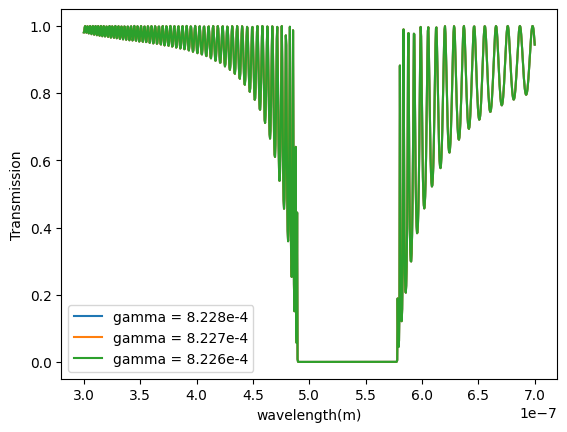

In [5]:
gamma = 0
medium_ex = PeriodicLayersExcited(medium,[gamma,gamma])
output1 = calculateSpectrum(medium_ex,i, 3e-7,7e-7,1000,n_layers,False)
gamma = 0
medium_ex = PeriodicLayersExcited(medium,[gamma,gamma])
output2 = calculateSpectrum(medium_ex,i, 3e-7,7e-7,1000,n_layers,False)
gamma = 0
medium_ex = PeriodicLayersExcited(medium,[gamma,gamma])
output3 = calculateSpectrum(medium_ex,i, 3e-7,7e-7,1000,n_layers,False)

plt.figure();
plt.plot(output1["lamda"],output1["T"], label ="gamma = 8.228e-4")
plt.plot(output2["lamda"],output2["T"], label ="gamma = 8.227e-4")
plt.plot(output2["lamda"],output3["T"], label ="gamma = 8.226e-4")
plt.xlabel("wavelength(m)")
plt.ylabel("Transmission")
plt.legend()

NameError: name 'medium' is not defined

0    1.500000e-07
Name: lamda, dtype: float64


In [2]:
from scipy.integrate import odeint
h = 6.62607015e-34
c = 3e8

def model(z,t,P_a):
    P_e = z[0]
    n1 = z[1]
    n2 = z[2]
    dn2dt = -(sigma*P_e/(h*f_e*S)+1/tau_21+sigma*P_a*(1+math.exp(-sigma*n1*L))/(2*h*f_a*S))*n2+N*P_a*(1-math.exp(-sigma*n1*L))/(h*f_a*n1*L*S)
    dP_edt = (c/n)*(sigma*P_e+k*h*f_e*S/tau_21)*n2-P_e/tau_c
    dn1dt = -dn2dt
    return [dP_edt,dn1dt,dn2dt]

def simulateDynamics(P_e0 , n10 , n20 , P_a , delta_t , f_a_in , f_e_in , S_in , L_in , n_in, params = {}, show = False):
    #Set device variables
    global f_a
    f_a = f_a_in
    global f_e
    f_e = f_e_in
    global S
    S = S_in
    global L
    L = L_in
    global n
    n = n_in
    
    #Set material variables
    global N
    N = params.get("N",2e24)
    global sigma
    sigma = params.get("sigma",2e-20)
    global tau_21
    tau_21 = params.get("tau_21",3e-9)
    global tau_c
    tau_c = params.get("tau_c",1.83e-13) 
    global k
    k = params.get("k",0.0001)
    
    
    z0 = [P_e0,n10,n20]
    output = pd.DataFrame({"t":[0] , "P_a":[P_a[0]] , "P_e":[P_e0] , "n1":[n10], "n2":[n20]})
    for i in range(len(P_a)):
        z = odeint(model,z0,[i*delta_t,(i+1)*delta_t],args=(P_a[i],))
        output = pd.concat([output,pd.DataFrame({"t":[delta_t*(i+1)] , "P_a":[P_a[i]] , "P_e":[z[1][0]] , "n1":[z[1][1]], "n2":[z[1][2]]})])
        z0 = z[1]
    if show:
        plt.figure()
        #plt.plot(output["t"],output["n1"],label='n1(t)')
        plt.plot(output["t"],output["n2"],label='n2(t)')
        #plt.plot(output["t"],output["n3"],label='n3(t)')
        plt.ylabel('population density')
        plt.xlabel('time(s)')
        plt.legend(loc='best')
        plt.show()
    return output


In [173]:
1/(3e8*1e4/1.375)

4.583333333333334e-13

In [17]:
P_a = 500*[0]+4*(550*[3])
N = 2e24
n10 = N
n20 = 0
delta_t = 0.15e-10
f_a_in = 3e8/(4e-7)
f_e_in = 3e8/(5.73e-7)
S_in = 4e-10
L_in = 2e-5


P_in = []
n_2 = []
for i in range(50):
    P_in += [i*0.4]
    
    P_a = 5000*[i*0.4]
    output = simulateDynamics(0 , n10 , n20 , P_a , delta_t , f_a_in , f_e_in , S_in , L_in, 1.375)
    n_2 += [output.iloc[4999]["n2"]*1e-6]





In [3]:
P_a1 = 50*[0]+550*[3]    
output1 = simulateDynamics(0 , n10 , n20 , P_a1 , delta_t , f_a_in , f_e_in , S_in , L_in, 1.375)
P_a2 = 50*[0]+550*[6]
output2 = simulateDynamics(0 , n10 , n20 , P_a2 , delta_t , f_a_in , f_e_in , S_in , L_in, 1.375)
P_a3 = 50*[0]+550*[9]
output3 = simulateDynamics(0 , n10 , n20 , P_a3 , delta_t , f_a_in , f_e_in , S_in , L_in, 1.375)
P_a4 = 50*[0]+550*[12]
output4 = simulateDynamics(0 , n10 , n20 , P_a4 , delta_t , f_a_in , f_e_in , S_in , L_in, 1.375)
#P_a5 = 50*[0]+500*[12]
#output5 = simulateDynamics(0 , n10 , n20 , P_a5 , delta_t , f_a_in , f_e_in , S_in , L_in, 1.375)


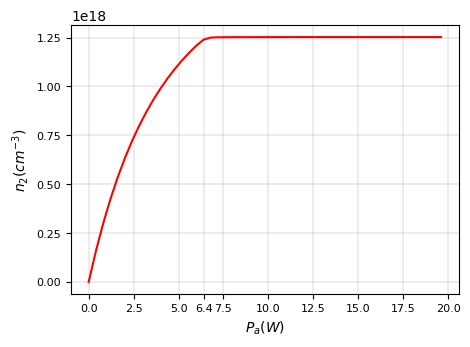

In [19]:
plt.figure(figsize=(5,3.5))
#plt.plot(1e9*output1["t"],1e-6*output1["n2"],'blue',linestyle = 'dotted',label='$P_{a} = 3W$')
#plt.plot(1e9*output2["t"],1e-6*output2["n2"],'green',linestyle = 'dotted',label='$P_a = 6W$')
plt.plot(P_in,n_2,'red')
#plt.plot(1e9*output4["t"],1e-6*output4["n2"],'red',label='$P_a = 12W$')
plt.ylabel('$n_2(cm^{-3})$')
plt.xlabel('$P_a(W)$')
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.xticks([0,2.5,5.0,6.4,7.5,10.0,12.5,15.0,17.5,20.0],fontsize=8)
plt.yticks([0,0.25e18,0.5e18,0.75e18,1e18,1.25e18],fontsize=8)
plt.savefig("5_2_n.pdf")

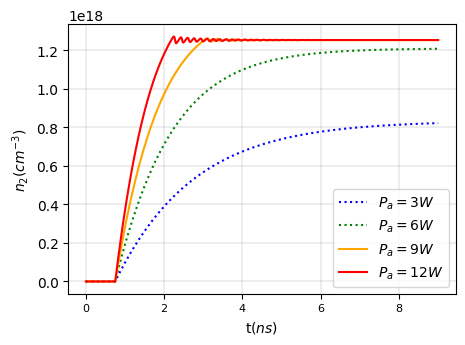

In [6]:
plt.figure(figsize=(5,3.5))
plt.plot(1e9*output1["t"],1e-6*output1["n2"],'blue',linestyle = 'dotted',label='$P_{a} = 3W$')
plt.plot(1e9*output2["t"],1e-6*output2["n2"],'green',linestyle = 'dotted',label='$P_a = 6W$')
plt.plot(1e9*output3["t"],1e-6*output3["n2"],'orange',label='$P_a = 9W$')
plt.plot(1e9*output4["t"],1e-6*output4["n2"],'red',label='$P_a = 12W$')
plt.ylabel('$n_2 (cm^{-3})$')
plt.xlabel('t($ns$)')
plt.legend(loc='best')
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.xticks(fontsize=8)
#plt.yticks([0,0.25e18,0.5e18,0.75e18,1e18,1.25e18],fontsize=8)
plt.savefig("4_3_2_n.pdf")

In [24]:
print(output3.tail)

<bound method NDFrame.tail of                t  P_a       P_e            n1            n2
0   0.000000e+00    0  0.000000  2.000000e+24  0.000000e+00
0   1.500000e-11    0  0.000000  2.000000e+24  0.000000e+00
0   3.000000e-11    0  0.000000  2.000000e+24  0.000000e+00
0   4.500000e-11    0  0.000000  2.000000e+24  0.000000e+00
0   6.000000e-11    0  0.000000  2.000000e+24  0.000000e+00
..           ...  ...       ...           ...           ...
0   8.190000e-09    9  2.970711  7.477329e+23  1.252267e+24
0   8.205000e-09    9  2.970711  7.477329e+23  1.252267e+24
0   8.220000e-09    9  2.970711  7.477329e+23  1.252267e+24
0   8.235000e-09    9  2.970711  7.477329e+23  1.252267e+24
0   8.250000e-09    9  2.970711  7.477329e+23  1.252267e+24

[551 rows x 5 columns]>


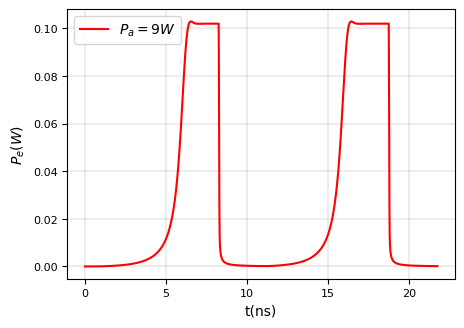

In [46]:
plt.figure(figsize=(5,3.5))
#plt.plot(1e9*output1["t"],output1["P_e"],'blue',linestyle = 'dotted',label='$P_{a} = 3W$')
#plt.plot(1e9*output2["t"],output2["P_e"],'green',linestyle = 'dotted',label='$P_a = 6W$')
plt.plot(1e9*output3["t"],output3["P_e"],'red',label='$P_a = 9W$')
#plt.plot(1e9*output4["t"],output4["P_e"],'red',label='$P_a = 12W$')
plt.ylabel('$P_e(W)$')
plt.xlabel('t(ns)')
plt.legend(loc='best')
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig("4_3_2_p.pdf")

In [37]:

7.16e23*2e-20*(5.73e-7)/(2*math.pi*1.375)

0.0009497626209807378

In [4]:
(2*math.pi*1.375*1.66e-3)/(2e-20*5.73e-7)

1.251428487228395e+24

In [209]:
p = 0.314e-6
alpha = 0.07
L = 25e-6

4*p**2/(alpha**2*L**3)

5151.137959183671

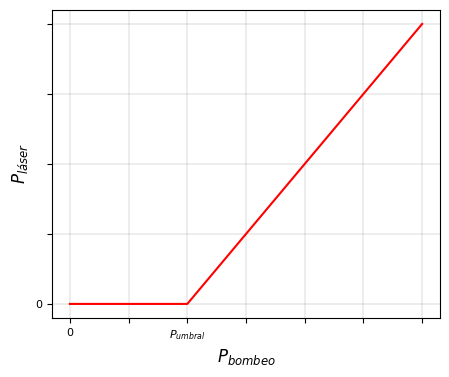

In [18]:
plt.figure(figsize=(5,4))
plt.plot([0,1,3],[0,0,2],'red')
plt.ylabel('$P_{láser}$',fontsize=12)
plt.xlabel('$P_{bombeo}$',fontsize=12)
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.xticks([0,0.5,1,1.5,2,2.5,3],["0","","$P_{umbral}$","","","",""],fontsize=8)
plt.yticks([0,0.5,1,1.5,2],["0","","","","",],fontsize=8)
plt.savefig("bombeo.pdf")